In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import yaml
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchaudio
import librosa
import numpy as np
from tqdm import tqdm
from datetime import datetime

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
with open('config/vars.yml') as f:
    VARS = yaml.load(f, yaml.Loader)

flnA = VARS['flnA']
flnB = VARS['flnB']

args = VARS['args']

In [4]:
base_model = torchaudio.models.ConvTasNet()  # torch.hub.load('sigsep/open-unmix-pytorch', 'umxhq')

In [5]:
base_model.training = False
covtasnet_encoder = base_model._modules['encoder']

In [6]:
inputA, _ = librosa.load(args['audio_path'] + flnA, sr=args['sr'], mono=True)
inputB, _ = librosa.load(args['audio_path'] + flnB, sr=args['sr'], mono=True)

# same size
length = min(len(inputA), len(inputB))
inputA = inputA[:length]
inputB = inputB[:length]

C:\Users\danie\anaconda3\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [7]:
A_t = torch.from_numpy(np.ascontiguousarray(inputA[None, None, :])).float() 
B_t = torch.from_numpy(np.ascontiguousarray(inputB[None, None, :])).float() 

In [8]:
covtasnet_encoder(A_t).shape

torch.Size([1, 512, 19294])

### Model (using ConvTasNet implicitly)

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = covtasnet_encoder
        self.selu = nn.SELU()
    def forward(self, A, B, Y):
        # CONTENT (shape (None, 287, 4096))
        a = self.selu(self.cnn(A.to(device))).squeeze(-1)
        b = self.selu(self.cnn(B.to(device))).squeeze(-1)
        y = self.selu(self.cnn(Y.to(device))).squeeze(-1)
        # STYLE (shape (None, 4096, 4096))
        g_b = torch.matmul(b, torch.transpose(b, 1, 2))
        g_y = torch.matmul(y, torch.transpose(y, 1, 2))
        Q = b.shape[1]  # XXX * b.shape[2]  # Q=NM
        g_b = torch.divide(g_b, Q)
        g_y = torch.divide(g_y, Q)
        return a, g_b, y, g_y

In [10]:
reference_amp = (torch.mean(A_t).item() + torch.mean(B_t)).item()
Y_t = torch.from_numpy(np.random.rand(*A_t.shape) * 100 * reference_amp).float()
Y_t.requires_grad = True
model = NeuralNetwork()

In [11]:
model.to(device)

NeuralNetwork(
  (cnn): Conv1d(1, 512, kernel_size=(16,), stride=(8,), padding=(8,), bias=False)
  (selu): SELU()
)

In [12]:
# OPTIMIZATION
criterion_content = torch.nn.MSELoss(reduce='sum')
criterion_style = torch.nn.MSELoss(reduce='sum')
optimizer = torch.optim.AdamW([Y_t], lr=.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.5, 7, threshold=0.001)
# fight against overfitting the content:
last_style_loss = np.inf
count_style_loss_augmen = 0

losses_style = []
losses_content = []
losses = []

for iter in range(500):
    print("Epoch", iter)
    ## forward:
    a, g_b, y, g_y = model(A_t, B_t, Y_t)
    # normalization const for style Gram:
    loss_content = 2 * criterion_content(a, y)
    loss_style = 2 * criterion_style(g_b, g_y) * 300
    loss = loss_content + loss_style
    print("content loss", loss_content)
    losses_content.append(loss_content.detach().cpu().numpy())
    print('style loss', loss_style)
    losses_style.append(loss_style.detach().cpu().numpy())
    print("Loss:", loss)
    losses.append(loss.detach().cpu().numpy())
    ## backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # update step
    scheduler.step(loss_style)  # XXX SCHEDULE USING ONLY ON THE LOSS_STYLE
    # early stop
    if loss_style > last_style_loss:
        count_style_loss_augmen += 1
    else:
        count_style_loss_augmen = 0
    if count_style_loss_augmen > 10:
        print('too many consecutive style losses achieved -> EARLY STOPPING')
        break  # early stop!
    last_style_loss = loss_style

C:\Users\danie\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch 0
content loss tensor(0.0296, device='cuda:0', grad_fn=<MulBackward0>)
style loss tensor(10.5989, device='cuda:0', grad_fn=<MulBackward0>)
Loss: tensor(10.6284, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1
content loss tensor(0.0413, device='cuda:0', grad_fn=<MulBackward0>)
style loss tensor(15.4060, device='cuda:0', grad_fn=<MulBackward0>)
Loss: tensor(15.4473, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 2
content loss tensor(0.0301, device='cuda:0', grad_fn=<MulBackward0>)
style loss tensor(8.2239, device='cuda:0', grad_fn=<MulBackward0>)
Loss: tensor(8.2540, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 3
content loss tensor(0.0298, device='cuda:0', grad_fn=<MulBackward0>)
style loss tensor(9.7547, device='cuda:0', grad_fn=<MulBackward0>)
Loss: tensor(9.7845, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 4
content loss tensor(0.0334, device='cuda:0', grad_fn=<MulBackward0>)
style loss tensor(3.7506, device='cuda:0', grad_fn=<MulBackward0>)
Loss: tensor(3.7839, device=

## Retrieve result

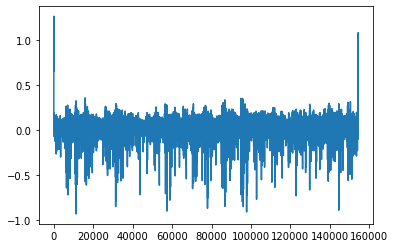

In [13]:
plt.plot(Y_t.detach().cpu().numpy().squeeze())

In [14]:
from scipy.io.wavfile import write
Y_n = Y_t.detach().numpy().squeeze()
Y_n /= np.max(Y_n)
Y_n *= np.iinfo(np.int16).max
write(VARS['audio_results_path'] + 'TEST.wav', args['sr'], Y_n.astype(np.int16))
